In [1]:
from IPython.display import HTML, display

# <font color='green'>Hodgkin-Huxley Neuron Model </font>

Hodgkin-Huxley model is the most 'complete' mathematical description of the action-potential generation in biological neurons. The model is complete in the sense that it provides mathematical equations that fit well with the voltage and time dependence of two most promiment currents involved in the generation of the action potential. 

## <font color='green'>Aims of the tutorial </font>
### Simulate a Hodgkin-Huxley model
### Study the effect of change in the conductance of the Na and K channels
### Generate the input current and output firing rate curve

## <font color='green'>Learnign outcomes</font>
### An understanding of various components that affect the action potential e.g. threshold, shape and amplitude

## <font color='green'>What will you do</font>
### Execute the Python code and display the results and describe your observations
### Write small code snippetes to perform certain simulations in loop

## <font color='green'>Equivalent electrical circuit</font>
A neuron membrane can be described as an electrical circuit with batteris, voltage dependent resistors and a capacitor. 
<img src="./Figures/neuron_synapse_circuit_model.png">

-  $C_m$ is the passive membrane capacitance
-  $g_n$ are the active voltage-gated ion channels represented by electrical conductances (where 'n' is the specific ion channel) that depend on both voltage and time
-  $g_L$ is the passive leak channel which accounrs for baseline flow of ions across the membrane and is represented by a linear conductance
-  $E_n$ are the gradients driving the flow of ions (determined by intra- and extracellular concentrations and permeability of ions)
- $g_{exc}$ is the excitatory synaptic conductance -- the so called 'conductance-based' synapse model
- $g_{inh}$ is the inhibitory synaptic conductance -- the so called 'conductance-based' synapse model
- $I_{exc}$ and $I_{inh}$ inhibotory synaptic currents -- when synapses are modelled as 'current-injections' as opposed to 'conductance changes'


## <font color='green'>The model</font>

The differential equations governing the dynamics of voltage is given by:

\begin{eqnarray*}
C_m\frac{dV}{dt} & = & g_L(V-E_L) + \bar{g_{Na}}m^3h(V-E_{Na}) + \bar{g_K}n^4(V-E_K) + I_{inj} \\
\frac{dm}{dt} & = & \alpha_m(1-m)-\beta_mm \\
\frac{dh}{dt} & = & \alpha_h(1-h)-\beta_hh \\
\frac{dn}{dt} & = & \alpha_n(1-n)-\beta_nn 
\end{eqnarray*}

-  $I_{inj}$ is the injected current
-  $\bar{g_n}$ are the maximum conductances for a given channel (sodium Na, potassium K, and leak L) 
-  $E_n$ are the reversal potentials for a given channel 
-  $n$, $m$, and $h$ are the gating variables
-  $\alpha_x$ and $\beta_x$ are voltage dependent variable (see below)

## <font color='green'>Voltage-dependent rate variables</font>

$\alpha$ and $\beta$ are the voltage-dependent rates at which the activation and inactivation gates are opening or closing, respectively.

\begin{eqnarray*}
\alpha_m & = & \frac{-0.2 (V+25)}{exp\big(2.5 -\frac{V+50}{10}\big)-1} \\
\beta_m & = & 4~exp\big(-\frac{V+50}{18}\big) \\
\alpha_h & = & 0.07~exp\big(-\frac{V+40}{20}\big) \\
\beta_h & = & \frac{1}{exp\big(3-\frac{V+40}{10}\big)+1} \\
\alpha_n & = & -\frac{0.01 (V-10)}{exp\big(1 - \frac{V+20}{10}\big)-1} \\
\beta_n & = & 0.0125~exp\big(-\frac{V+20}{80}\big) \\
\end{eqnarray*}

In the following cell we have python functions to calculate the values of $\alpha$ and $\beta$ variables and their steady state values of $m$, $h$, $n$

In [2]:
import numpy as np
import pylab as plt
import matplotlib as matplt
%matplotlib inline
from scipy.integrate import odeint
np.random.seed(1000)


In [3]:
# Sodium ion-channel rate functions
def alpha_m(Vm):
    return (0.1 * (- Vm - 25.)) / (np.exp(2.5 - (0.1 * (Vm + 50.))) - 1.0)

def beta_m(Vm):
    return 4.0 * np.exp(-(Vm + 50.) / 18.0)

def alpha_h(Vm):
    return 0.07 * np.exp(-(Vm + 40.) / 20.0)

def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * (Vm + 40.))) + 1.0)
  
# Pottasium ion-channel rate functions
def alpha_n(Vm):
    return (0.015 * (10.0 - Vm - 20.)) / (np.exp(1.0 - (0.1 * (Vm + 20.) )) - 1.0)

def beta_n(Vm):
    return 0.125 * np.exp(-(Vm + 20.) / 80.0)

# n, m, and h steady-state values

def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

## <font color='green'>Activation and inactivation curves of NA and K</font>

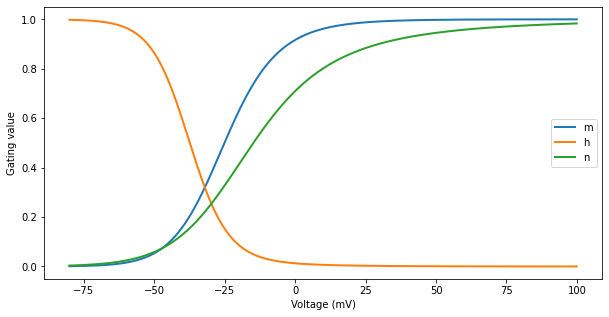

In [4]:
# Votage dependence of m, h, and n
voltage = np.arange(-80, 100, 0.1)
M = m_inf(voltage)
H = h_inf(voltage)
N = n_inf(voltage)

plt.figure(figsize=(10, 5))
plt.plot(voltage, M,linewidth=2, label=r'm')
plt.plot(voltage, H,linewidth=2, label=r'h')
plt.plot(voltage, N,linewidth=2, label=r'n')
plt.xlabel('Voltage (mV)')
plt.ylabel('Gating value')
plt.legend()
plt.show()

# <font color=blue>Describe</font>
### What do these shapes indicate? 

These curves indicate the limit values of of the different gating variables as voltage increases. The limit is in terms of time approaching infinity.

### What can we predict about the shape, amplitude and threshold of an action potential?

I don't think we can predict the shape of the action potential from these curves alone as we need to know how the different time constants relate to each other. We can say that if the resting voltage of the cell is in the area where h = 0 or very small, the cell will only be conducive to potassium.


In [5]:
def compute_derivatives(y, t0):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (I_inj(t0) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy

In [6]:
# Start and end time (in milliseconds)
tmin = 0.0
tmax = 200.0

# Average potassium channel conductance per unit area (mS/cm^2)
gK = 80.0

# Average sodoum channel conductance per unit area (mS/cm^2)
gNa = 120.0

# Average leak channel conductance per unit area (mS/cm^2)
gL = 0.3

# Membrane capacitance per unit area (uF/cm^2)
Cm = 1.0

# Potassium potential (mV)
VK = -70.0

# Sodium potential (mV)
VNa = 50.0

# Leak potential (mV)
Vl = -65.

# Time values
T = np.linspace(tmin, tmax, 10000)

# Potassium ion-channel rate functions

In [7]:
# Input stimulus -- The following generates a Current Pulse 
# of amplitude 'stim_amp', which starts as 'stim_start' and ends at 'stim_end'
# Vary the input strength and stimulation durtion here
def I_inj(t, stim_amp = 7., stim_start = 30.0, stim_end = 130.):
    if 0.0 < t < stim_start:
        return 0.0
    elif stim_start < t < stim_end:
        return stim_amp
    elif stim_end < t < 191.0:
        return 0.0
    return 0.0

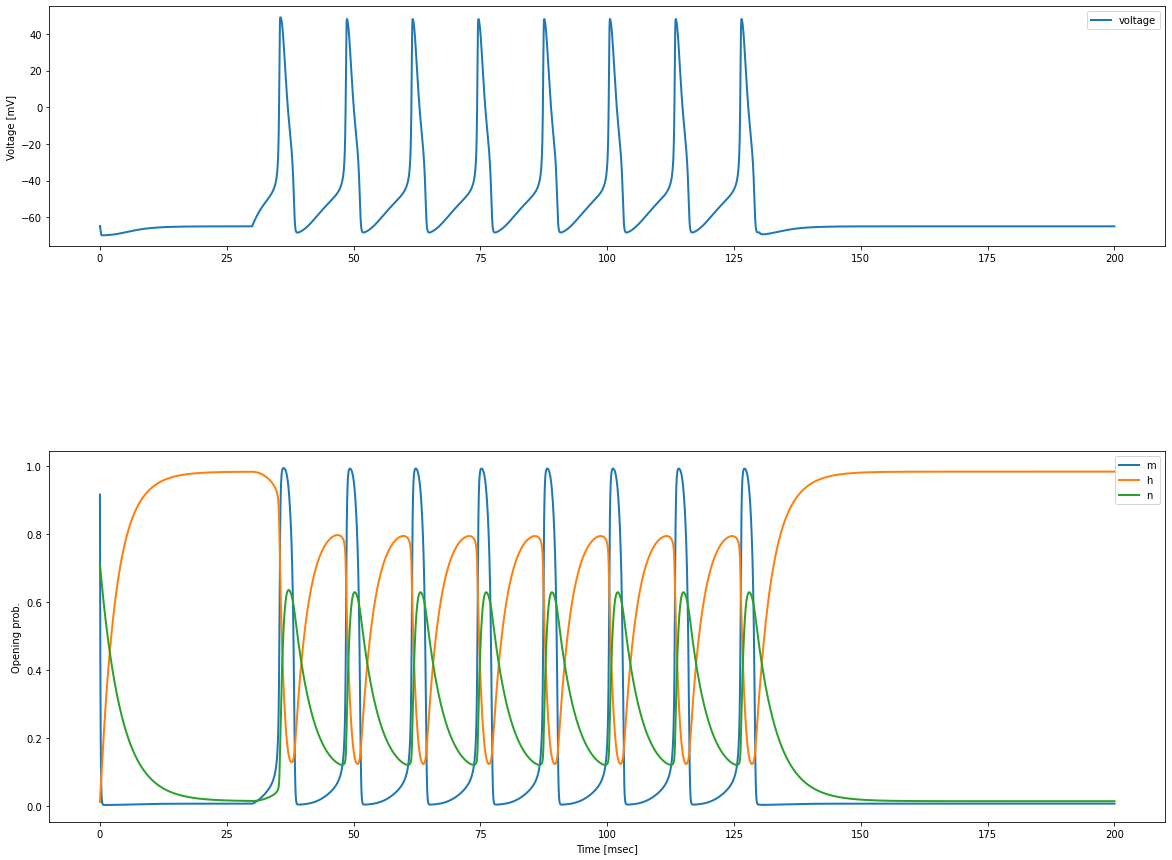

In [8]:
# State (Vm, n, m, h)
Y = np.array([-65.0, n_inf(), m_inf(), h_inf()])
# Solve ODE system
Vy = odeint(compute_derivatives, Y, T)

# Plot the results
plt.figure(figsize=(20, 15))
plt.subplot(311)
plt.plot(T,Vy[:,0],linewidth=2,label='voltage')
plt.legend()
plt.ylabel('Voltage [mV]')
plt.subplot(212)
plt.plot(T,Vy[:,2],linewidth=2,label='m')
plt.plot(T,Vy[:,3],linewidth=2,label='h')
plt.plot(T,Vy[:,1],linewidth=2,label='n')
plt.ylabel('Opening prob.')
plt.xlabel('Time [msec]')
plt.legend()

plt.show()

# <font color=blue>Describe</font>
### How do the opening and closing of the Na and K channels relate to the shape of the action potential 
### Which channels are closed and opened in different phases of the action potential


# <font color=salmon>TO DO</font>
## Vary the Na conductance (gNa) and K conductance (gK) and study 
### 1. how the number of action potentials generated varies as a function of gNa and gK
### 2. how the shape of the action potentials varies as a function of gNa and gK
#### <font color=gray> Write a small code to count the number of action potentials. To this end you can write a small code to determine threshold cross from below. For this model you can set the spike threshold to -20mV. Alternatively, you can count the spikes manually. You can also write a small script to loop over different values of gNa and gK</font>

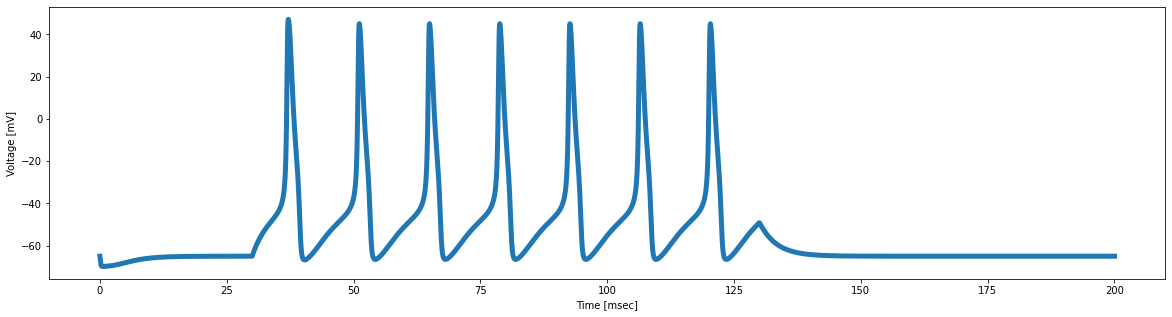

In [9]:
gK = 60
gNa = 50
Y = np.array([-65.0, n_inf(), m_inf(), h_inf()])
# Solve ODE system
Vy = odeint(compute_derivatives, Y, T)
plt.figure(figsize=(20, 5))
plt.plot(T,Vy[:,0],linewidth=5)
plt.xlabel('Time [msec]')
plt.ylabel('Voltage [mV]')
plt.show()

# <font color=green>Spike threshold</font>
## There are two ways to determine the spike threshold
### 1. Determine the minimum current necessary to generate an action potential. This is also referred to as Rheobase
### 2. We can also find the voltage at the double derivative of the action potential waveform is maximal as shown below

In [10]:
# Spike threshold at the point of maximum double derivative
def get_max_accelearation(vm):
    vm2 = np.diff(vm)
    #vm2 = np.diff(vm1)
    vm2 = (vm2-np.mean(vm2))/np.std(vm2)
    vm2[vm2<2.5]=0;
    xx = np.diff(vm2);
    xx[xx<0]=0;
    xx[xx>0]=1;
    dx = np.diff(xx)
    dx[dx<0]=0
    thr_ids = np.where(dx==1.)
    thr_cross = thr_ids[0]+3
    return thr_cross

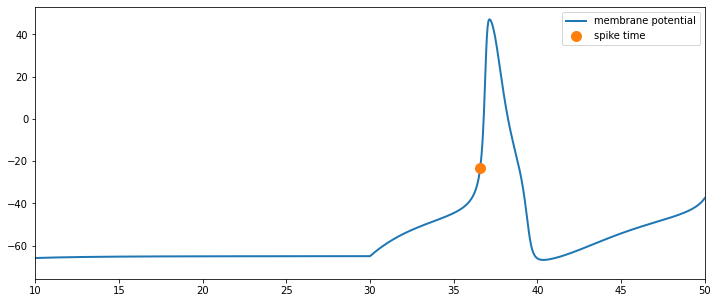

In [11]:
vm = Vy[:,0]
spk_id = get_max_accelearation(vm)

plt.figure(figsize=(12, 5))
plt.plot(T,vm,linewidth=2,label='membrane potential')
plt.plot(T[spk_id],vm[spk_id],'o',ms = 10,linewidth=5,label='spike time')
plt.xlim((10,50))
plt.legend()
plt.show()

# <font color=salmon>TO DO</font>
### Vary the Na conductance (gNa) and K conductance (gK) and study spike threshold

# <font color=green>Input current and output spike count</font>
### Adapt the code below and study how input current amplitude determines the number of spikes

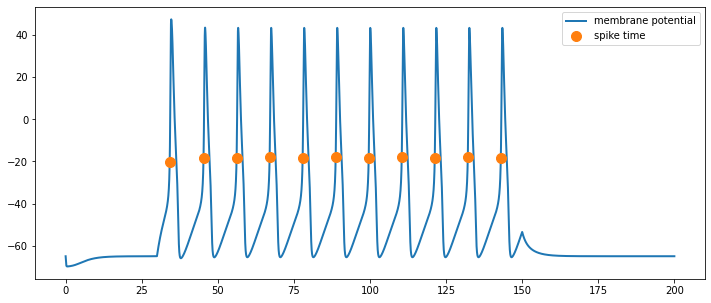

In [12]:
# Calculate the effect of injected current on the spike count
# Input stimulus
# Vary the input strength and stimulation durtion here
def I_inj(t, stim_amp = 10., stim_start = 30.0, stim_end = 150.):
    if 0.0 < t < stim_start:
        return 0.0
    elif stim_start < t < stim_end:
        return stim_amp
    elif stim_end < t < 200.0:
        return 0.0
    return 0.0

Y = np.array([-65.0, n_inf(), m_inf(), h_inf()])
# Solve ODE system
Vy = odeint(compute_derivatives, Y, T)
vm = Vy[:,0]
spk_id = get_max_accelearation(vm)

spike_count = len(spk_id)
spike_count

plt.figure(figsize=(12, 5))
plt.clf()
plt.plot(T,vm,linewidth=2,label='membrane potential')
plt.plot(T[spk_id],vm[spk_id],'o',ms = 10,linewidth=5,label='spike time')
#plt.xlim((2500,8000))
plt.legend()
plt.show()

# <font color=salmon>TO DO</font>
### Study the effect of injected current on the spike count
#### <font color=gray>Write a loop around the above code and plot spike count as a function of injected current amplitude</font>


# <font color=salmon>TO DO</font>
### In the above exercise you may have noticed that the number of spikes start to decrease at very high current amplitudes. Why does that happen? 
#### Investigate this by plotting the membrane voltage and corresponding K and Na openning/closing variables.

# <font color=salmon>TO DO</font>
### How can we estimate the effective time constant of the HH model? Think of a way and estimate the time constant
#### Describe what complications may arise in this way of estimation